In [1]:
# Delete output of previous run
# !rm -rf *.in.* species* *.out* *.inp* *.log*

In [2]:
import mosdef_cassandra as mc
import generate_mc as gen   # Chris' script
import mbuild as mb
import foyer
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import random
import unyt as u    # For Cassandra's physical unit specification 
                    # https://mosdef-cassandra.readthedocs.io/en/latest/guides/unyts.html

In [3]:
def gen_system(dims=[2, 2, 2]):
    defaults_dict = {'stoichiometry': {'Mo': 1, 'V': 0.15, 'Nb': 0.13, 'Te': 0.12},
                     'dimensions': dims,
                     'template': 'M1UnitCell_mod.pdb',
                     'crystal_x': 2.148490,
                     'crystal_y': 2.664721,
                     'crystal_z': 0.400321,
                     'z_reactor_size': 20.0,
                     'forcefield': None
                     }

    system = gen.Surface(defaults_dict['dimensions'],
                        defaults_dict['template'],
                         defaults_dict['stoichiometry'],
                         True,
                         defaults_dict['crystal_x'],
                         defaults_dict['crystal_y'],
                         defaults_dict['crystal_z']
                        )
    system.translate_to(np.zeros(3)) # Added so that periodicity doesn't error out
    system.periodicity = system.boundingbox.lengths # necessary
    #system.to_parmed() # Triggers an error
    return system

In [13]:
def apply_ff(system, systemFF, organicFF=None):
    typed_surface = systemFF.apply(system.children[0],
                            assert_angle_params=False,
                            assert_bond_params=False,
                            assert_dihedral_params=False,
                            assert_improper_params=False)
    if organicFF:
        for idx, child in enumerate(system.children):
            if idx == 0:
                pass
            else:
                typed_comp = organicFF.apply(child)
                typed_surface += typed_comp
    return typed_surface

In [14]:
mc.utils.detect_cassandra_binaries();

Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe


Jump to Isotherm stuff [HERE](#ai)

In [15]:
surface = gen_system(dims=[1, 1, 1])
surface.visualize(show_ports=True, color_scheme={'O':'red',
                                               'Te': 'black',
                                               'V': 'black',
                                               'Nb': 'black',
                                               'Mo': 'black'})

Adding [0, 0, 0] to system... 


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
type(surface)

generate_mc.Surface

In [13]:
ethane = mb.load("CC", smiles=True)
ethane.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
# Load forcefields
opls_uff = foyer.forcefields.Forcefield(forcefield_files='forcefields/FF_opls_uff_M1.xml')
oplsaa = foyer.forcefields.load_OPLSAA()

# Use foyer to apply forcefields
typed_surface = apply_ff(surface, opls_uff)
typed_ethane = oplsaa.apply(ethane)

# Create box and species list
box_list = [surface]
species_list = [typed_surface, typed_ethane]

/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


In [19]:
print('surface.boundingbox.lengths:', surface.boundingbox.lengths)
print('min(surface.boundingbox.lengths)/2.1:',min(surface.boundingbox.lengths)/2.1)

surface.boundingbox.lengths: [2.0970999  2.65140007 0.44999999]
min(surface.boundingbox.lengths)/2.1: 0.21428570860908144


In [16]:
%%bash

# Delete output of previous run
rm -rf *.in.* species* *.out* *.inp* *.log*

In [17]:
# Since we have an occupied box we need to specify
# the number of each species present in the intial config
mols_in_boxes = [[1,0]]

system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
moves = mc.Moves("gcmc", species_list)    # Grand Canonical Monte Carlo

custom_args = {
    "chemical_potentials": ["none", float(-30.0* u.kelvin)],
    "rcut_min": float(0.5* u.angstrom),
    "vdw_cutoff": (min(surface.boundingbox.lengths)/3)* u.angstrom, #min(box.lengths)/2.1, # OG: 14.0, 
    "charge_style": "none",
    #"charge_cutoff": 14.0,
    "coord_freq": 100,
    "prop_freq": 10,
}

mc.run(system=system, 
       moves=moves, 
       run_type="equilibration", 
       run_length=10000, 
       temperature= float(300 * u.K), **custom_args)

Treating <Structure 160 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe
Generating fragment libraries...


/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:178: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn("No bonds found. Cassandra will interpet "
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:564: UserWarning: More than two atoms present but no fragments identified.
  warnings.warn('More than two atoms present but '
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_135 will be shortened to six characters as ls_135. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_140 will be shortened to six characters as ls_140. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))


Running Cassandra...


In [18]:
!tail -n 1 mosdef*.log # Should say "Cassandra simulation complete"

 Cassandra simulation complete


In [15]:
%%bash

# move the output
mkdir output
mv *.in.* species* *.out* *.inp* output

/home/nealeellyson/CassandraSim


mkdir: cannot create directory ‘output’: File exists
mv: cannot stat ‘*.in.*’: No such file or directory
mv: cannot move ‘species1’ to ‘output/species1’: File exists
mv: cannot move ‘species2’ to ‘output/species2’: File exists
mv: cannot stat ‘*.out*’: No such file or directory
mv: cannot stat ‘*.inp*’: No such file or directory


In [27]:
import ex_render_cassandra as erc
import os
import getpass

# These cells are for visualizing output
xyzfile = f"prod_{chem_pot:.0f}_{temp:.0f}.out.xyz"
boxfile = f"prod_{chem_pot:.0f}_{temp:.0f}.out.H"
traj = erc.make_traj(xyzfile, boxfile)
print("Frames: ",len(traj))

cwd = os.getcwd()
username = getpass.getuser()
print("Copy this into Ovito Load Remote File:\n") # From Fry
print('sftp://'+username+'@fry'+cwd+'/'+xyzfile)

Copy this into Ovito Load Remote File:
/home/nealeellyson/CassandraSim/output/gcmc.out.xyz


In [26]:
xyzfile = "output/gcmc.out.xyz"
boxfile = "output/gcmc.out.H"

traj = erc.make_traj(xyzfile, boxfile)

In [27]:
erc.display_movie(erc.render_sphere_frame, traj)
#erc.display_movie(erc.render_sphere_frame, traj, gif="traj.gif")

# Errors:
`Initial vdw cutoff is greater than half the minimum box length
This error occurred in subroutine Get_Pair_Style on step 0.`

Jenny: 
> Fixed by making the boxlist an empty box with correct size

My fix:
```
"vdw_cutoff": min(surface.boundingbox.lengths)/3,
"charge_style": "none",
#"charge_cutoff": 14.0,
```

Open in VMD in terminal with `vmd [filename]`

ovito
set up x11 forwarding
on fry: ssh -Y -> asks for x11 forwarding

## Copy from LJ_example notebook in cassandra_example

<a id="ai"></a>
### Adsorption Isotherm & Energy Plot



In [5]:
L = 10
box = mb.Box(mins=[-L/2]*3, maxs=[L/2]*3)


surface = gen_system(dims=[1, 1, 2]) # Should be double layer
#Test surface size, we care about the surface being thick enough, 
#but gap is not a key thing and could be issue with MC sims
surface.periodicity = surface.periodicity + np.array([0,0,1.4-0.85032099]) # Make (14 in A, convert from nm), only room for an ethane
# Centering???
surface.translate_to([0,0,0]) 
surface.visualize(show_ports=True, color_scheme={'O':'red',
                                               'Te': 'black',
                                               'V': 'black',
                                               'Nb': 'black',
                                               'Mo': 'black'})
ethane = mb.load("CC", smiles=True)
#ethane.visualize().show()

Adding [0, 0, 1] to system... 


In [6]:
# Load forcefields
opls_uff = foyer.forcefields.Forcefield(forcefield_files='forcefields/FF_opls_uff.xml')
oplsaa = foyer.forcefields.load_OPLSAA()

# Use foyer to apply forcefields
typed_surface = apply_ff(surface, opls_uff)
typed_ethane = oplsaa.apply(ethane, assert_bond_params=False, assert_angle_params=False, 
    assert_dihedral_params=False)

/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/forcefield.py:433: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/forcefield.py:445: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
/home/nealeellyson/miniconda3/envs/mc/l

In [7]:
def run_cassandra_surf(chem_pot, temp):
    # Create box and species list
    box_list = [surface]
    species_list = [typed_surface,typed_ethane]

    # Since we have an occupied box we need to specify
    # the number of each species present in the intial config
    mols_in_boxes = [[2,0]]

    system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
    moves = mc.Moves("gcmc", species_list)

    custom_args = {
        "run_name": f"surfequil_{chem_pot:.0f}_{temp:.0f}",
        "chemical_potentials": ["none",chem_pot],
        "rcut_min": 0.3980 * 2.5, #(or 3.0)
        "vdw_cutoff": min(box.lengths)/2.1,
        "charge_style": "none",
        #"charge_cutoff": 14.0,
        "coord_freq": 100,
        "prop_freq": 10,
    }

    mc.run(
        system=system, 
        moves=moves, 
        run_type="equilibration", 
        run_length=3600549, # To reach ~1.33 hours
        temperature=temp, 
        **custom_args
    )
    
    # Set max translate and volume for production
    moves.max_translate = [[0,10.0]] # angstroms

    # Update run_name and restart_name
    custom_args["run_name"] = f"surfprod_{chem_pot:.0f}_{temp:.0f}"
    custom_args["restart_name"] = f"surfequil_{chem_pot:.0f}_{temp:.0f}"

    mc.restart(
        system=system,
        moves=moves,
        run_type="production",
        run_length=24097256, # To reach ~6.67 hours, total 8 hrs
        temperature=temp,
        **custom_args,
    )

#### W/rt equilibration
We can tweak trial move stuff within Cassandra and could dramatically improve equilibration times

#### W/rt box size
We want a surface with ethane absorbing into it and the box height above to only focus on things absorbing into the surface. The problem is the other side of the surface and if the space is too small where the molecules can't fit between the two. But if we make it too far then we have a middle area. 

[Lab Meeting Notes Here](https://etherpad.boisestate.edu/p/ldrd-s20-9)
Where we discuss equilibration, box size, 

In [52]:
!rm -f box*xyz
#!rm -f surf*_33.out.log

In [8]:
eps = typed_ethane.atoms[0].epsilon
print(f"epsilon: {eps:.2f}")
print("sigma: ", typed_ethane.atoms[0].sigma)
# ParmEd is in kcal/mol

kb = 0.001985875    # kcal/(mol K)
T = eps/kb

print(f"The unit temperature is {T:.0f} K")
chem_pots = [i*T for i in range(0,10)] #[33] #
temp = 2*T

epsilon: 0.07
sigma:  3.5
The unit temperature is 33 K


In [9]:
chem_pots

[0.0,
 33.23472021149368,
 66.46944042298736,
 99.70416063448104,
 132.93888084597472,
 166.1736010574684,
 199.40832126896208,
 232.64304148045576,
 265.87776169194944,
 299.11248190344315]

In [ ]:
for chem_pot in chem_pots:
    run_cassandra_surf(chem_pot,temp)
    !rm -f box*xyz  # it won't overwrite the box...

Treating <Structure 160 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe
Generating fragment libraries...


/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:178: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn("No bonds found. Cassandra will interpet "
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:564: UserWarning: More than two atoms present but no fragments identified.
  warnings.warn('More than two atoms present but '
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_135 will be shortened to six characters as ls_135. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_140 will be shortened to six characters as ls_140. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))


Running Cassandra...
Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe
Running Cassandra...


In [22]:
# If you want to check whether your run completed successfully
# This should say "Cassandra simulation complete"
!tail -n 1 mosdef*.log

==> mosdef_cassandra_2020-07-09_15:33:45.631426.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:11:55.857635.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:12:15.206624.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:12:59.911363.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:13:20.306337.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:14:08.456281.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:14:29.096669.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:15:17.412289.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:15:38.611830.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:16:29.489494.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_16:16:50.446840.log <==
 Cassandra simulation complete

==> mosdef_cassandra_2020-07-09_

In [10]:
import ex_render_cassandra as erc
import os
import getpass

# These cells are for visualizing output
#xyzfile = f"surfprod_{chem_pot:.0f}_{temp:.0f}.out.xyz"
#boxfile = f"surfprod_{chem_pot:.0f}_{temp:.0f}.out.H"
#traj = erc.make_traj(xyzfile, boxfile)
#print("Frames: ",len(traj))

for chem_pot in chem_pots:
    cwd = os.getcwd()
    username = getpass.getuser()
    xyzfile = f"surfprod_{chem_pot:.0f}_{temp:.0f}.out.xyz"
    print("\n\tCopy this into Ovito Load Remote File:") # From Fry
    print('sftp://'+username+'@fry'+cwd+'/'+xyzfile)


	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_0_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_33_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_66_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_100_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_133_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_166_66.out.xyz

	Copy this into Ovito Load Remote File:
sftp://nealeellyson@fry/home/erjank_project/nealeellyson/CassandraSim_arg/surfprod_199_66.out.xyz

	Copy this into Ovito Load Rem

In [6]:
# prp file is different when nmols is different
T = 33
chem_pots = [i*T for i in range(0,10)] #[33] #
temp = 2*T
pressures = []
nmols = []
for chem_pot in chem_pots:
    try:
        a = np.loadtxt(f"surfprod_{chem_pot:.0f}_{temp:.0f}.out.prp")
    except:
        pass
    print(a)
    pressures.append(np.mean(a[:,5]))
    nmols.append(np.mean(a[:,8]))

[[3.6005100e+06 2.7996765e+05 2.7809726e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [3.6005200e+06 2.7996945e+05 2.7809943e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [3.6005300e+06 2.7996716e+05 2.7809763e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 ...
 [2.4097230e+07 2.7997976e+05 2.7808506e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [2.4097240e+07 2.7997788e+05 2.7808343e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [2.4097250e+07 2.7997749e+05 2.7808369e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]]
[[3.6005100e+06 2.7996765e+05 2.7809726e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [3.6005200e+06 2.7996945e+05 2.7809943e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [3.6005300e+06 2.7996716e+05 2.7809763e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 ...
 [2.4097230e+07 2.7997976e+05 2.7808506e+05 ... 2.0000000e+00
  4.3000000e+01 2.7869724e+03]
 [2.4097240e+07 2.7997788e+05 2.7808343e+05 ... 2.0000000e+

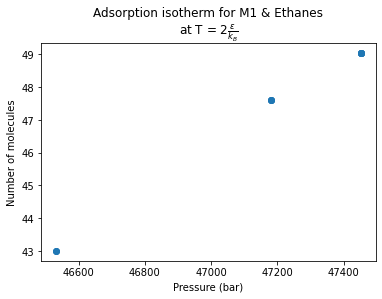

In [19]:
plt.title(r"""Adsorption isotherm for M1 & Ethanes
at T = 2$\frac{\epsilon}{k_{B}}$""")
plt.scatter(pressures,nmols)
plt.xlabel("Pressure (bar)")
plt.ylabel("Number of molecules")
plt.show()
# graph below suggests we need to go to higher potential(??)--not quite levelling off

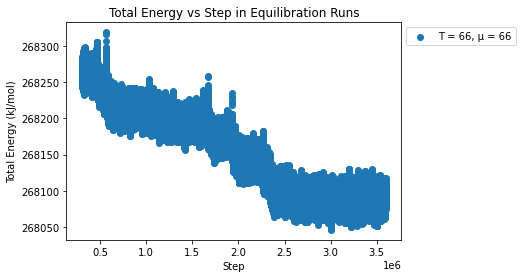

In [44]:
# if we wanted to check whether our system was equilibrated we could the equil
# property files (.prp)

# STEP Energy_Total Energy_Intra Energy_Inter Enthalpy Pressure Volume Nmols Mass_Density  
#     (kJ/mol)-Ext  (kJ/mol)-Ext (kJ/mol)-Ext          (bar)    (A^3)        (kg/m^3) 

chem_pots = [66]

for chem_pot in chem_pots:
    try:
        a = np.loadtxt(f"surfequil_{chem_pot:.0f}_{temp:.0f}.out.prp")
        plt.scatter(a[30000:,0],a[30000:,1], label=f"T = {temp:.0f}, μ = {chem_pot:.0f}")
    except:
        pass

plt.xlabel("Step")
plt.ylabel("Total Energy (kJ/mol)")
plt.title("Total Energy vs Step in Equilibration Runs")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

# Time step calculation:

In [8]:
!tail -n 4 surfequil*out.log

==> surfequil_0_66.out.log <==
         0    Minutes
        11    Seconds
       999         ms
********************************************************************************

==> surfequil_100_66.out.log <==
         0    Minutes
        13    Seconds
       536         ms
********************************************************************************

==> surfequil_133_66.out.log <==
         0    Minutes
        13    Seconds
       495         ms
********************************************************************************

==> surfequil_166_66.out.log <==
         0    Minutes
        13    Seconds
       646         ms
********************************************************************************

==> surfequil_199_66.out.log <==
         0    Minutes
        13    Seconds
       415         ms
********************************************************************************

==> surfequil_233_66.out.log <==
         0    Minutes
        13    Seconds
       827         m

In [17]:
surfequil_299_66 = 13.978
surfequil_266_66 = 13.957
surfequil_233_66 = 13.827
surfequil_199_66 = 13.415
surfequil_166_66 = 13.646
surfequil_133_66 = 13.495
surfequil_100_66 = 13.536
surfequil_66_66  = 12.984
surfequil_33_66  = 12.476
surfequil_0_66   = 11.999
surfequil = [
13.978,
13.957,
13.827,
13.415,
13.646,
13.495,
13.536,
12.984,
12.476,
11.999,
]

surfprod_299_66 = 51.405
surfprod_266_66 = 52.386
surfprod_233_66 = 54.479
surfprod_199_66 = 51.133
surfprod_166_66 = 50.418
surfprod_133_66 = 49.504
surfprod_100_66 = 51.350
surfprod_66_66  = 47.590
surfprod_33_66  = 45.486
surfprod_0_66   = 44.231
surfprod = [
51.405,
52.386,
54.479,
51.133,
50.418,
49.504,
51.350,
47.590,
45.486,
44.231,
]

In [24]:
import numpy as np
equil = np.average(surfequil)
prod = np.average(surfprod)
equilrun = 10000
prodrun = 50000
idealtime = 8*3600

In [44]:
idealequil = equilrun/equil*idealtime/6

In [45]:
idealprod = prodrun/prod*idealtime/6*5

In [46]:
idealprod

24097256.527344365

In [47]:
idealequil

3600549.08373527

In [49]:
idealtime/6/3600

1.3333333333333333

In [50]:
idealtime/6*5/3600

6.666666666666667